# Training: Hybrid Model v1:
- Pets + Supermarket skus
- Bert Multi Model Base


In [1]:
!pip install unidecode python-dotenv Unidecode==1.3.6 google-cloud-aiplatform transformers==4.27.4 tensorflow==2.8.4 tensorflow-text==2.8.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 47.2 MB/s eta 0:00:00
INFO: pip is looking at multiple vers

## libs

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import requests
from collections import Counter
import re
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import time

import glob
from ast import literal_eval

import io
import math

import warnings
warnings.filterwarnings("ignore")

from numpy.linalg import norm
from matplotlib import colors

import pickle
from dotenv import load_dotenv
import json


from password import *

from vertexai.preview.language_models import TextEmbeddingModel
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'automatch-309218-5f83b019f742.json'

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from transformers import BertTokenizer, TFBertModel
import tensorflow_text as text

import warnings
warnings.filterwarnings("ignore")

## TPU

In [2]:
##para configuracion TPU

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
#if tf.config.list_physical_devices('GPU'):
#  strategy = tf.distribute.MirroredStrategy()
#  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


## GCP Credentials

In [3]:
project_id = 'automatch-309218'
!gcloud config set project {project_id}

!gcloud auth login
!gcloud auth application-default login

REGION = "us-central1"
BUCKET_URI = 'gs://pets-match-v2-21-12-23'

Updated property [core/project].
Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=6lgX8VDP0hyYJGjSv1hw1WNiHp9oAS&prompt=consent&token_usage=remote&access_type=offline&code_challenge=YPHrPzJ5DwNGCXVpT-3uYYnwwFDCKH2aPwtGmA5Xv9A&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AdLIrYdUscEmNfkslZWa__FSSCQt2DqcJTIl63qEDOzuBkieZpms3lYe-oFWqSAh5CO4XA

You are now logged in as [ia@geti.cl].

## GCP Txt embedding model

In [4]:
embedding_model_gcp = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

def get_embedding_txt_gcp(text, model=embedding_model_gcp):
    """returns the embedding for a string using gcp embedding model"""
    text = text.replace("\n", " ")
    embedding = model.get_embeddings([text])
    embedding = embedding[0].values
    return embedding

## Bert Modal & tokenizer

In [5]:
#BERT multi

bert_multi = 'bert-base-multilingual-uncased'
#Loading tokenizer
tokenizer= BertTokenizer.from_pretrained(bert_multi)

MAX_LENGTH = 35

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [6]:
def join_products(product_1, product_2):
  join = [f'{p1} [SEP] {p2}' for p1,p2 in zip(product_1,product_2)]
  return join

## Dataset en TF Records

In [7]:
!gsutil cp gs://pets-match-v2-21-12-23/ds_train_hybrid_10-05-24.csv .
!gsutil cp gs://pets-match-v2-21-12-23/ds_eval_hybrid_10-05-24.csv .
!gsutil cp gs://pets-match-v2-21-12-23/ds_test_hybrid_10-05-24.csv .


Copying gs://pets-match-v2-21-12-23/ds_train_hybrid_10-05-24.csv...
- [1 files][ 50.8 MiB/ 50.8 MiB]                                                
Operation completed over 1 objects/50.8 MiB.                                     
Copying gs://pets-match-v2-21-12-23/ds_eval_hybrid_10-05-24.csv...
/ [1 files][  6.3 MiB/  6.3 MiB]                                                
Operation completed over 1 objects/6.3 MiB.                                      
Copying gs://pets-match-v2-21-12-23/ds_test_hybrid_10-05-24.csv...
/ [1 files][  6.3 MiB/  6.3 MiB]                                                
Operation completed over 1 objects/6.3 MiB.                                      


In [8]:
ds_train = pd.read_csv('ds_train_hybrid_10-05-24.csv', index_col=0)
ds_eval = pd.read_csv('ds_eval_hybrid_10-05-24.csv', index_col=0)
ds_test = pd.read_csv('ds_test_hybrid_10-05-24.csv', index_col=0)

In [9]:
def decode_fn2(sample, max_length=MAX_LENGTH):
    features = {
        "input_ids": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
        "attention_mask": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
        #"token_type_ids": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
    }
    labels = {
        "labels": tf.io.FixedLenFeature((1,), dtype=tf.int64)
    }
    x = tf.io.parse_example(sample, features)
    y = tf.io.parse_example(sample, labels)

    return ((x),y)

def generate_tfrecords_data(chunk_ds, chunk_labels, file_name, max_length=MAX_LENGTH ):
  #chunk:
  tokenized_data = tokenizer(
      list(chunk_ds),
      padding="max_length",
      truncation=True,
      max_length=max_length,
      return_tensors="np",
  )

  labels = chunk_labels #already in numpy array

  with tf.io.TFRecordWriter(f"{file_name}.tfrecords") as file_writer:
    for i in range(len(labels)):
        features = {
            "input_ids": tf.train.Feature(
                int64_list=tf.train.Int64List(value=tokenized_data["input_ids"][i])
            ),
            "attention_mask": tf.train.Feature(
                int64_list=tf.train.Int64List(value=tokenized_data["attention_mask"][i])
            ),
            #"token_type_ids": tf.train.Feature(
            #    int64_list=tf.train.Int64List(value=tokenized_data["token_type_ids"][i])
            #),
            "labels": tf.train.Feature(
                int64_list=tf.train.Int64List(value=[labels[i]])
            ),
        }
        features = tf.train.Features(feature=features)
        example = tf.train.Example(features=features)
        record_bytes = example.SerializeToString()
        file_writer.write(record_bytes)

In [10]:
len(ds_train), len(ds_eval), len(ds_test)

(470416, 58802, 58800)

In [11]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 64
tf_records_folder = 'tf_records_ds/hybrid_model_ds'

ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{tf_records_folder}/ds_train_hybrid_p1.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_train_hybrid_p2.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_train_hybrid_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(470416 // BATCH_SIZE) #len(y_train) = 470416 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{tf_records_folder}/ds_eval_hybrid_p1.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_eval_hybrid_p2.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_eval_hybrid_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(58802 // BATCH_SIZE) #len(y_valid) = 58802.
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{tf_records_folder}/ds_test_hybrid_p1.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_test_p2.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_test_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

## Training

In [12]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [13]:
with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1 = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = 'hybrid_model_txt_v1_loss.h5'
    filepath2 = 'hybrid_model_txt_v1_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #checkpoint3 = ModelCheckpoint(filepath3, monitor='val_recall', verbose=1, \
    #                              save_best_only=True, save_weights_only=True, \
    #                              mode='auto', save_frequency=1)

    early_stop = EarlyStopping(monitor='val_loss', patience=15)


    #initial learning rate & optimizer
    lr = 2e-6
    optimizer = tf.keras.optimizers.Adam(lr)

    #learning rate schedule --> for exploring the plateu when stuck in locals minimals
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        learning_rate=lr,
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
        mode='auto'
    )

    #compile model
    model_txt_1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
for index,layer in enumerate(model_txt_1.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7e7c56d51d80> False
1 <keras.engine.input_layer.InputLayer object at 0x7e7c165c3fd0> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7e7da2067f10> False
3 <keras.layers.pooling.GlobalMaxPooling1D object at 0x7e7c16a90e50> True
4 <keras.layers.pooling.GlobalAveragePooling1D object at 0x7e7c16adbbe0> True
5 <keras.layers.merge.Concatenate object at 0x7e7c166ff610> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7e7c13e71450> True
7 <keras.layers.core.dense.Dense object at 0x7e7c13b64040> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7e7c16a82fe0> True
9 <keras.layers.core.dropout.Dropout object at 0x7e7c13f69420> True
10 <keras.layers.core.dense.Dense object at 0x7e7c13b67850> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7e7c13f6bf10> True
12 <keras.layers.core.dropout.Dropout object at 0x7e7c

In [15]:
start = time.time()
epochs = 30


history_1 = model_txt_1.fit(ds_training,validation_data=ds_validating, epochs=epochs, callbacks=[reduce_lr,checkpoint1, checkpoint2, early_stop])

end = time.time()
total_time = end-start
print(f'time taken to train model ({epochs} epochs): {total_time} secs')

Epoch 1/30


7350/7350 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.7889 - auc: 0.8692 - precision: 0.7894 - recall: 0.7880
Epoch 1: val_loss improved from inf to 0.24322, saving model to hybrid_model_txt_v1_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.90734, saving model to hybrid_model_txt_v1_acc.h5
7350/7350 [==============================] - 750s 92ms/step - loss: 0.4956 - accuracy: 0.7889 - auc: 0.8692 - precision: 0.7894 - recall: 0.7880 - val_loss: 0.2432 - val_accuracy: 0.9073 - val_auc: 0.9665 - val_precision: 0.9345 - val_recall: 0.8761 - lr: 2.0000e-06
Epoch 2/30
7350/7350 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8879 - auc: 0.9468 - precision: 0.8885 - recall: 0.8870
Epoch 2: val_loss improved from 0.24322 to 0.16976, saving model to hybrid_model_txt_v1_loss.h5

Epoch 2: val_accuracy improved from 0.90734 to 0.93990, saving model to hybrid_model_txt_v1_acc.h5
7350/7350 [==============================] - 685s 93ms/step -

In [20]:
20743.58/3600

5.762105555555556

## Evaluating

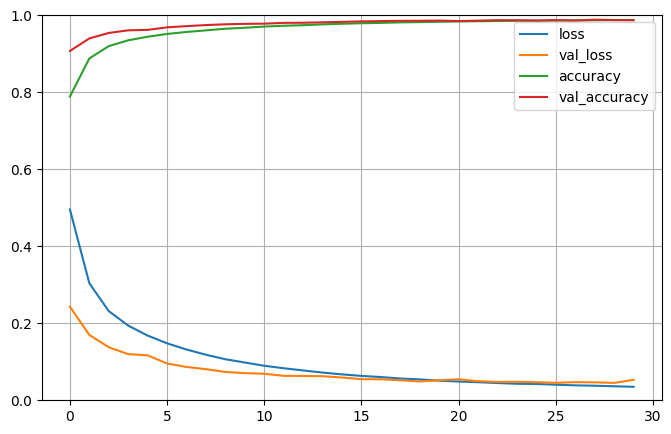

In [16]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

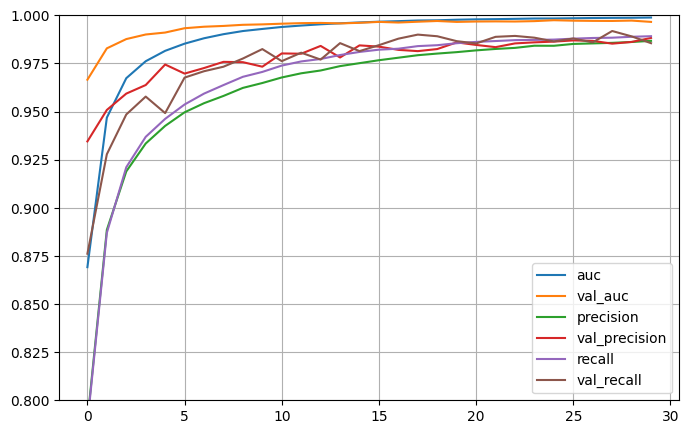

In [17]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [18]:
#evaluate
model_txt_1.evaluate(ds_testing)

306/306 [==============================] - 14s 31ms/step - loss: 0.0589 - accuracy: 0.9865 - auc: 0.9960 - precision: 0.9876 - recall: 0.9853


[0.058868732303380966,
 0.9864685535430908,
 0.9959835410118103,
 0.9875948429107666,
 0.9852715730667114]

In [19]:
models_folder = 'models_checkpoints'
!gsutil cp /content/hybrid_model_txt_v1_acc.h5 {BUCKET_URI}/{models_folder}
!gsutil cp /content/hybrid_model_txt_v1_loss.h5 {BUCKET_URI}/{models_folder}

Copying file:///content/hybrid_model_txt_v1_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/hybrid_model_txt_v1_loss.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which wo